In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=7226843e08b8e927b0783a75f8bec4d875d5583c3f854825d9feb08e1008a385
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


#MARKET NEUTRAL MOMENTUM TRADING STRATEGY

A 30-day momentum score is calculated for each stock using Rate of Change (ROC) and On-Balance Volume (OBV) indicators. These indicators are standardized to z-scores to ensure comparability across stocks.

Stocks are filtered based on momentum scores relative to predefined thresholds (t_long and t_short). Stocks with momentum scores above t_long are considered for long positions, while those below -t_short are considered for short positions.

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np

# 1. Define NIFTY 50 stock tickers
nifty_50_tickers = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "KOTAKBANK.NS", "ITC.NS", "LT.NS", "HINDUNILVR.NS", "SBIN.NS",
    "BHARTIARTL.NS", "BAJFINANCE.NS", "ASIANPAINT.NS", "DMART.NS",
    "MARUTI.NS", "AXISBANK.NS", "HCLTECH.NS", "M&M.NS", "ULTRACEMCO.NS",
    "TITAN.NS", "SUNPHARMA.NS", "ONGC.NS", "WIPRO.NS", "ADANIENT.NS",
    "NTPC.NS", "POWERGRID.NS", "INDUSINDBK.NS", "TATASTEEL.NS", "BAJAJFINSV.NS",
    "DIVISLAB.NS", "JSWSTEEL.NS", "TECHM.NS", "HDFCLIFE.NS", "CIPLA.NS",
    "BPCL.NS", "APOLLOHOSP.NS", "BRITANNIA.NS", "COALINDIA.NS", "HEROMOTOCO.NS",
    "DRREDDY.NS", "TATAMOTORS.NS", "GRASIM.NS", "SBILIFE.NS", "EICHERMOT.NS",
    "UPL.NS", "NESTLEIND.NS", "SHREECEM.NS", "ADANIPORTS.NS", "BPCL.NS"
]

start_date = "2019-01-01"
end_date = "2023-12-31"

# 2. Download historical price data for NIFTY 50 stocks
data = yf.download(nifty_50_tickers, start="2018-01-01", end=end_date)['Adj Close']
data_v = yf.download(nifty_50_tickers, start="2018-01-01", end=end_date)['Volume']

# Remove timezone information
data.index = data.index.tz_localize(None)
data_v.index = data_v.index.tz_localize(None)

def calculate_momentum_scores(data, data_v):
    momentum_scores = pd.DataFrame()
    for ticker in data.columns:
        stock_data = data[ticker]
        stock_data_v = data_v[ticker]

        # Check if there is enough data to calculate indicators
        if len(stock_data) < 200:  # Adjusted to match ROC length
            # print(f"Not enough data to calculate indicators for {ticker}.")
            continue

        # Calculate momentum indicators
        roc = ta.roc(stock_data, length=200)
        obv = ta.obv(stock_data, volume=stock_data_v)

        # Create a DataFrame to consolidate all indicators
        indicators_df = pd.DataFrame({
            'ROC': roc,
            'OBV': obv
        })

        # Drop rows with any NaN values
        indicators_df.dropna(inplace=True)

        # If the DataFrame is empty after dropping NaNs, skip this ticker
        if indicators_df.empty:
            # print(f"Not enough valid data for {ticker} after dropping NaNs.")
            continue

        # Standardize each indicator (z-score)
        roc_std = (indicators_df['ROC'] - indicators_df['ROC'].mean()) / indicators_df['ROC'].std()
        obv_std = (indicators_df['OBV'] - indicators_df['OBV'].mean()) / indicators_df['OBV'].std()

        # Composite momentum score: weighted average
        momentum_scores[ticker] = 0.5 * roc_std + 0.5 * obv_std  # Adjust weights as needed

    return momentum_scores

# 4. Initialize trading variables
long_stock = None
short_stock = None
capital = 1000000  # Initial capital in INR
portfolio_value = capital  # Portfolio value
trading_days = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days without timezone

# Initialize long and short positions dictionaries
long_positions = {}
short_positions = {}

# Initialize a list to store portfolio value over time
portfolio_history = []

# 7. Loop through trading days
for date in trading_days:
    # Check if data is available for the current date
    if date not in data.index:
        # print(f"No data available for {date.date()}. Skipping.")
        portfolio_history.append(portfolio_value)
        continue

    # Calculate momentum scores up to the current date
    data_up_to_date = data.loc[:date]
    data_v_up_to_date = data_v.loc[:date]
    momentum_scores = calculate_momentum_scores(data_up_to_date, data_v_up_to_date)

    # Check if momentum scores are empty
    if momentum_scores.empty:
        portfolio_history.append(portfolio_value)
        continue

    final_momentum_scores = momentum_scores.iloc[-1].sort_values(ascending=False)

    # Define the threshold 't'
    t_long = 1.5
    t_short = 1

    # Filter stocks for new long and short positions
    new_long_stocks = final_momentum_scores[final_momentum_scores > t_long].index
    new_short_stocks = final_momentum_scores[final_momentum_scores < -t_short].index

    # Open new long positions
    if len(new_long_stocks) > 0:
        long_position_size = (portfolio_value * 0.5) / len(new_long_stocks)  # Allocate 50% to longs
        for stock in new_long_stocks:
            if stock not in long_positions:  # Only add if not already in long positions
                long_entry_price = data[stock].loc[date]
                print(f"{date.date()}: Go long on {stock} at ₹{long_entry_price:.2f} with position size: ₹{long_position_size:.2f}")
                long_positions[stock] = {'entry_price': long_entry_price, 'position_size': long_position_size}

    # Open new short positions
    if len(new_short_stocks) > 0:
        short_position_size = (portfolio_value * 0.5) / len(new_short_stocks)  # Allocate 50% to shorts
        for stock in new_short_stocks:
            if stock not in short_positions:  # Only add if not already in short positions
                short_entry_price = data[stock].loc[date]
                print(f"{date.date()}: Go short on {stock} at ₹{short_entry_price:.2f} with position size: ₹{short_position_size:.2f}")
                short_positions[stock] = {'entry_price': short_entry_price, 'position_size': short_position_size}

    # Check and square off long positions that fall below the threshold or hit stop-loss
    for stock in list(long_positions.keys()):
        long_exit_price = data[stock].loc[date]
        entry_price = long_positions[stock]['entry_price']
        position_size = long_positions[stock]['position_size']

        # Check if the price has dropped by 5% (stop-loss condition)
        if (long_exit_price / entry_price) < 0.95:  # Stop-loss of 5%
            profit = (long_exit_price - entry_price) * (position_size / entry_price)
            portfolio_value += profit
            print(f"{date.date()}: Stop-loss triggered for long position on {stock} at ₹{long_exit_price:.2f} | Profit/Loss: ₹{profit:.2f}")
            del long_positions[stock]
        elif stock not in final_momentum_scores or final_momentum_scores[stock] < 1:  # Momentum score falls below threshold
            profit = (long_exit_price - entry_price) * (position_size / entry_price)
            portfolio_value += profit
            print(f"{date.date()}: Square off long position on {stock} at ₹{long_exit_price:.2f} | Profit: ₹{profit:.2f}")
            del long_positions[stock]

    # Check and square off short positions that rise above the threshold or hit stop-loss
    for stock in list(short_positions.keys()):
        short_exit_price = data[stock].loc[date]
        entry_price = short_positions[stock]['entry_price']
        position_size = short_positions[stock]['position_size']

        # Check if the price has risen by 5% (stop-loss condition)
        if (short_exit_price / entry_price) > 1.05:  # Stop-loss of 5%
            profit = position_size * (entry_price / short_exit_price - 1)
            portfolio_value += profit
            print(f"{date.date()}: Stop-loss triggered for short position on {stock} at ₹{short_exit_price:.2f} | Profit/Loss: ₹{profit:.2f}")
            del short_positions[stock]
        elif stock not in final_momentum_scores or final_momentum_scores[stock] > -0.5:  # Momentum score rises above threshold
            profit = position_size * (entry_price / short_exit_price - 1)
            portfolio_value += profit
            print(f"{date.date()}: Square off short position on {stock} at ₹{short_exit_price:.2f} | Profit: ₹{profit:.2f}")
            del short_positions[stock]


    # Record the current portfolio value
    portfolio_history.append(portfolio_value)

# After the loop, square off any remaining open positions at the last available price
for stock in list(long_positions.keys()):
    last_date = data.index[-1]
    long_exit_price = data[stock].loc[last_date]
    entry_price = long_positions[stock]['entry_price']
    position_size = long_positions[stock]['position_size']
    profit = (long_exit_price - entry_price) * (position_size / entry_price)
    portfolio_value += profit
    print(f"{last_date.date()}: Final square off long position on {stock} at ₹{long_exit_price:.2f} | Profit: ₹{profit:.2f}")
    del long_positions[stock]

for stock in list(short_positions.keys()):
    last_date = data.index[-1]
    short_exit_price = data[stock].loc[last_date]
    entry_price = short_positions[stock]['entry_price']
    position_size = short_positions[stock]['position_size']
    profit = position_size * (entry_price / short_exit_price - 1)
    portfolio_value += profit
    print(f"{last_date.date()}: Final square off short position on {stock} at ₹{short_exit_price:.2f} | Profit: ₹{profit:.2f}")
    del short_positions[stock]

# Update the portfolio history with the final portfolio value
portfolio_history.append(portfolio_value)

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  48 of 48 completed


2019-01-01: Go long on POWERGRID.NS at ₹80.89 with position size: ₹71428.57
2019-01-01: Go long on SBILIFE.NS at ₹591.61 with position size: ₹71428.57
2019-01-01: Go long on SBIN.NS at ₹282.00 with position size: ₹71428.57
2019-01-01: Go long on ADANIPORTS.NS at ₹375.10 with position size: ₹71428.57
2019-01-01: Go long on ADANIENT.NS at ₹155.25 with position size: ₹71428.57
2019-01-01: Go long on ICICIBANK.NS at ₹349.91 with position size: ₹71428.57
2019-01-01: Go long on BAJFINANCE.NS at ₹2608.04 with position size: ₹71428.57
2019-01-02: Go short on HCLTECH.NS at ₹399.58 with position size: ₹166666.67
2019-01-02: Go short on JSWSTEEL.NS at ₹264.23 with position size: ₹166666.67
2019-01-02: Go short on EICHERMOT.NS at ₹1859.34 with position size: ₹166666.67
2019-01-03: Go long on APOLLOHOSP.NS at ₹1243.75 with position size: ₹250000.00
2019-01-03: Go short on TATASTEEL.NS at ₹18.87 with position size: ₹125000.00
2019-01-03: Go short on M&M.NS at ₹671.33 with position size: ₹125000.00
2

In [ ]:
print("Length of portfolio_history:", len(portfolio_history))
print("Length of trading_days:", len(trading_days))
min_length = min(len(portfolio_history), len(trading_days))
portfolio_history = portfolio_history[:min_length]
trading_days = trading_days[:min_length]

Length of portfolio_history: 1304
Length of trading_days: 1304


#PERFOMANCE METRICS

#PROFIT

In [ ]:
print("Initial value of portfolio: ", portfolio_history[0])
print("Final value of portfolio: ", portfolio_history[-1])
print("Profit: ", portfolio_history[-1] - portfolio_history[0])

Initial value of portfolio:  1000000
Final value of portfolio:  2011076.113192681
Profit:  1011076.113192681


#ROI

In [ ]:
def calculate_roi(portfolio_history):

    beginning_value = portfolio_history[0]
    ending_value = portfolio_history[-1]

    try:
        roi = ((ending_value - beginning_value) / beginning_value) * 100
        return roi
    except ZeroDivisionError:
        return "Beginning value cannot be zero."

# Example usage
roi = calculate_roi(portfolio_history)
print(f"The ROI of your portfolio over the past 5 years is: {roi:.2f}%")

The ROI of your portfolio over the past 5 years is: 101.11%


#CAGR (Compound Annual Growth Rate)

In [ ]:
def calculate_cagr(portfolio_history, start_date, end_date):
    # Calculate the number of years between the start and end date
    n_years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25

    # Beginning and ending values of the portfolio
    beginning_value = portfolio_history[0]
    ending_value = portfolio_history[-1]

    # Calculate CAGR
    cagr = (ending_value / beginning_value) ** (1 / n_years) - 1
    return cagr * 100  # Convert to percentage

# Example usage
start_date = "2019-01-01"
end_date = "2023-12-31"
portfolio_cagr = calculate_cagr(portfolio_history, start_date, end_date)
print(f"The CAGR of your portfolio over 5 years is: {portfolio_cagr:.2f}%")


The CAGR of your portfolio over 5 years is: 15.01%


#ANNUALISED VOLATILITY

In [ ]:
def calculate_volatility(portfolio_history):

    # Calculate daily/periodic returns
    returns = [((portfolio_history[i] - portfolio_history[i-1]) / portfolio_history[i-1])
               for i in range(1, len(portfolio_history))]

    # Calculate standard deviation of returns (Volatility)
    volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility if daily data

    return volatility

# Example usage
volatility = calculate_volatility(portfolio_history)
print(f"The annualized volatility of your portfolio over the past 5 years is: {volatility:.4f}")

The annualized volatility of your portfolio over the past 5 years is: 0.3709


#SHARPE RATIO

In [ ]:
def calculate_sharpe_ratio(portfolio_history, risk_free_rate=0.07365/252):

    # Calculate daily/periodic returns
    returns = [((portfolio_history[i] - portfolio_history[i-1]) / portfolio_history[i-1])
               for i in range(1, len(portfolio_history))]

    # Calculate average return and volatility (standard deviation of returns)
    average_return = sum(returns) / 252
    volatility = np.std(returns)

    # Calculate the Sharpe ratio (annualized if daily returns)
    sharpe_ratio = (average_return - risk_free_rate) / (volatility)

    return sharpe_ratio

# Example usage
sharpe_ratio = calculate_sharpe_ratio(portfolio_history)
print(f"The Sharpe ratio of your portfolio over the past 5 years is: {sharpe_ratio:.4f}")


The Sharpe ratio of your portfolio over the past 5 years is: 0.1480


#SORTINO RATIO

In [ ]:
def calculate_sortino_ratio(portfolio_history, risk_free_rate=0.07365/252):

    # Calculate daily/periodic returns
    returns = [((portfolio_history[i] - portfolio_history[i-1]) / portfolio_history[i-1])
               for i in range(1, len(portfolio_history))]

    # Calculate the average return
    average_return = np.mean(returns)

    # Calculate downside deviation (only returns below risk-free rate)
    downside_returns = [r for r in returns if r < (risk_free_rate)]

    # If no downside returns exist, downside deviation is 0, Sortino ratio is undefined
    if len(downside_returns) == 0:
        return "No downside returns, cannot calculate Sortino ratio."

    downside_deviation = np.std(downside_returns)

    # Calculate the Sortino ratio (annualized for daily data)
    sortino_ratio = (average_return - (risk_free_rate)) / (downside_deviation)

    return sortino_ratio

# Example usage
sortino_ratio = calculate_sortino_ratio(portfolio_history, risk_free_rate=0.07365/252)
print(f"The Sortino ratio of your portfolio over the past 5 years is: {sortino_ratio:.4f}")


The Sortino ratio of your portfolio over the past 5 years is: 0.1424


#MAX DRAWDOWN

In [ ]:
# Convert portfolio history to a Pandas DataFrame for easier manipulation
portfolio_history_df = pd.DataFrame(portfolio_history, index=trading_days, columns=["Portfolio Value"])

# Calculate the running maximum (peak) of the portfolio value over time
running_max = portfolio_history_df['Portfolio Value'].cummax()

# Calculate the drawdown at each point: difference between the peak and current portfolio value
drawdown = portfolio_history_df['Portfolio Value'] - running_max

# Calculate drawdown percentage
drawdown_percent = drawdown / running_max

# Maximum drawdown is the minimum of the drawdown percentage
max_drawdown = drawdown_percent.min()

# Print the maximum drawdown value
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")


Maximum Drawdown: -37.65%


#PORTFOLIO VALUE WITH TIME

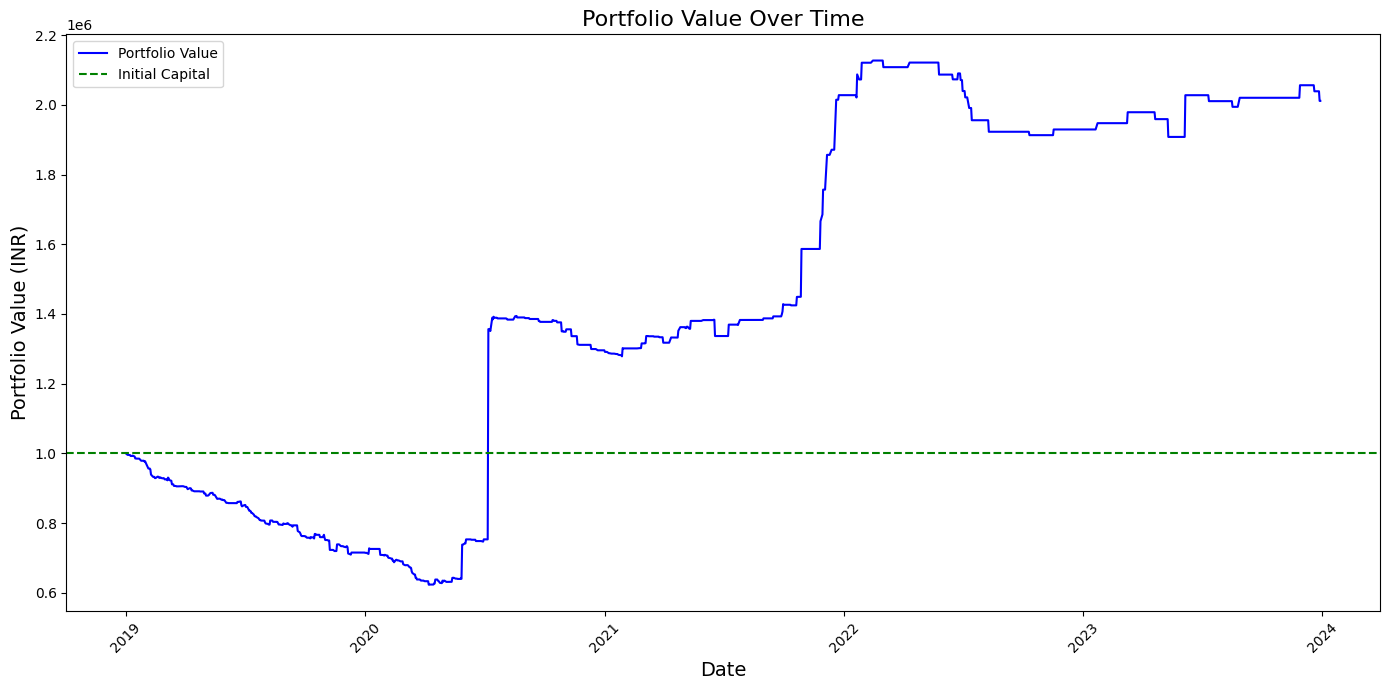

In [ ]:
import matplotlib.pyplot as plt

# Convert the portfolio history list to a DataFrame
portfolio_df = pd.DataFrame({'Portfolio Value': portfolio_history}, index=trading_days)

# Set the plot size for better readability
plt.figure(figsize=(14, 7))

# Plot the Portfolio Value
plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio Value', color='blue')

# Highlighting the Initial Capital
plt.axhline(y=capital, color='green', linestyle='--', label='Initial Capital')

# Adding Titles and Labels
plt.title('Portfolio Value Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value (INR)', fontsize=14)

# Adding a Legend
plt.legend()

# Enhancing the X-axis for better date representation
plt.xticks(rotation=45)
plt.tight_layout()

# Display the Plot
plt.show()


#PORTFOLIO DRAWDOWN WITH TIME

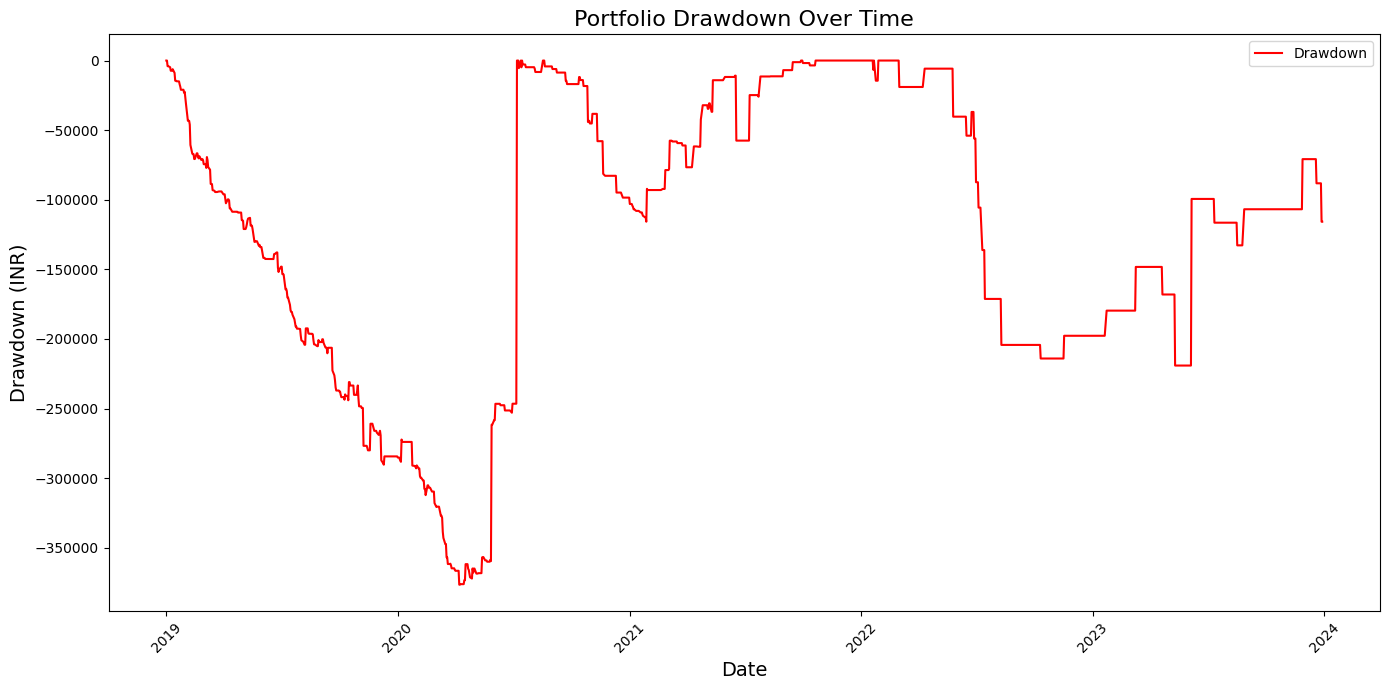

In [ ]:
# Calculate the running maximum (peak) of the portfolio value over time
running_max = portfolio_df['Portfolio Value'].cummax()

# Calculate the drawdown: difference between the peak and current portfolio value
drawdown = portfolio_df['Portfolio Value'] - running_max

# Plot the Drawdown over time
plt.figure(figsize=(14, 7))
plt.plot(drawdown, label='Drawdown', color='red')

# Add title and labels
plt.title('Portfolio Drawdown Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown (INR)', fontsize=14)

# Rotate x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend()

# Show the plot
plt.show()


#ROLLING SHARPE RATIO

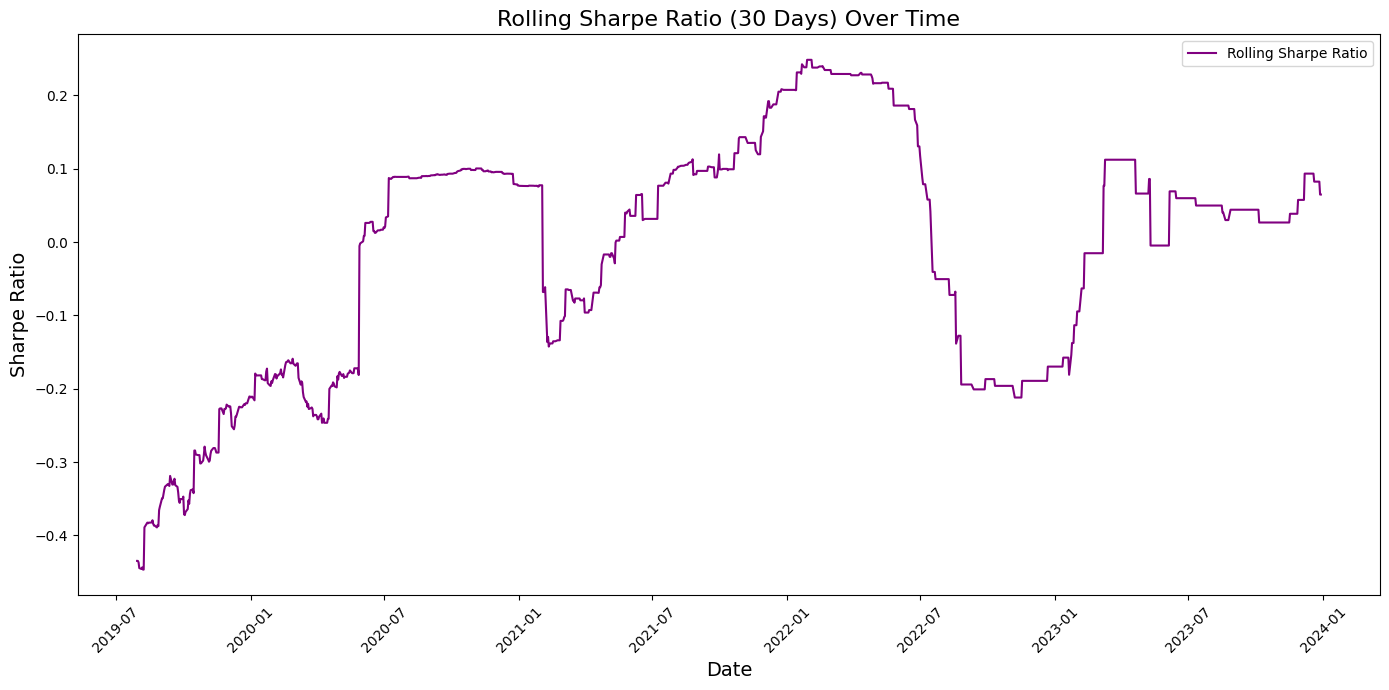

In [ ]:

portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()

rolling_window = 150

# Calculate rolling Sharpe Ratio: mean return / standard deviation of returns
rolling_sharpe_ratio = portfolio_df['Daily Return'].rolling(window=rolling_window).mean() / portfolio_df['Daily Return'].rolling(window=rolling_window).std()

# Plot Rolling Sharpe Ratio
plt.figure(figsize=(14, 7))
plt.plot(rolling_sharpe_ratio, label='Rolling Sharpe Ratio', color='purple')

plt.title('Rolling Sharpe Ratio (150 Days) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sharpe Ratio', fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()


plt.legend()

plt.show()


#ROLLING VOLATILITY

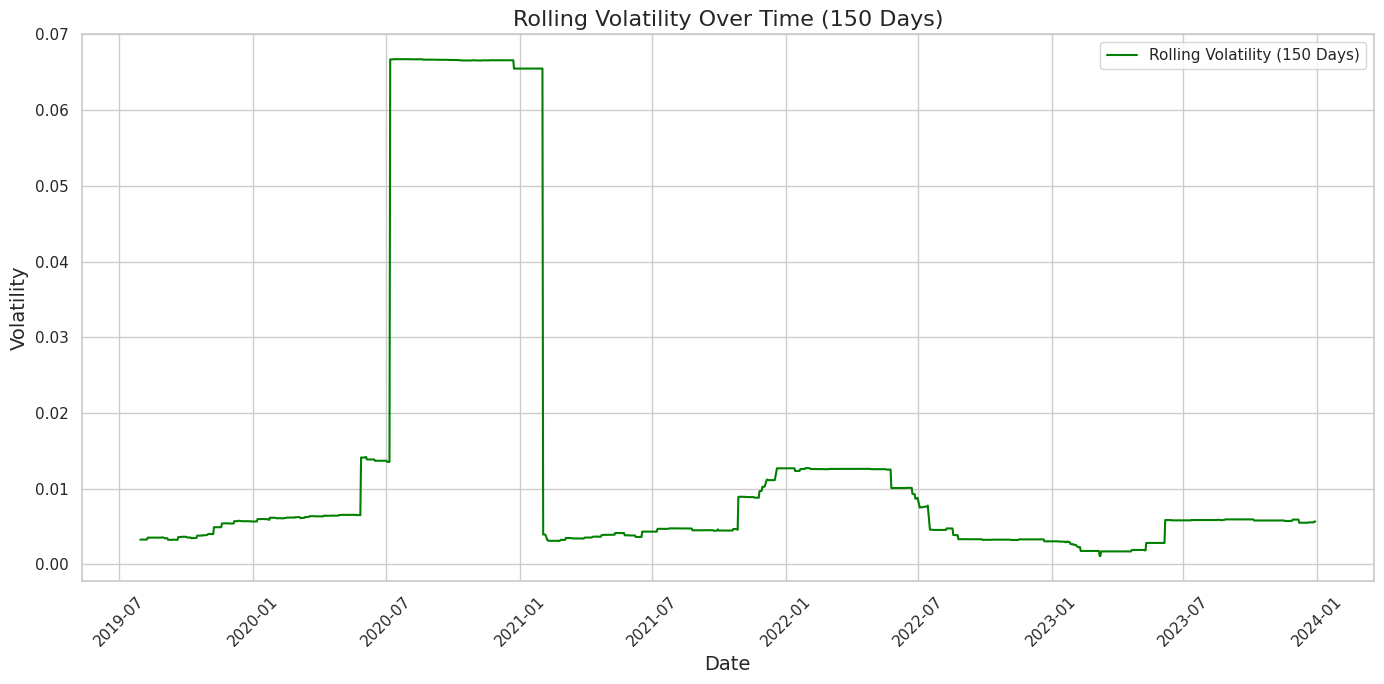

In [ ]:
# Calculate daily returns
portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()

rolling_volatility = portfolio_df['Daily Return'].rolling(window=150).std()

# Plot Rolling Volatility
plt.figure(figsize=(14, 7))
plt.plot(rolling_volatility, label='Rolling Volatility (150 Days)', color='green')

# Add title and labels
plt.title('Rolling Volatility Over Time (150 Days)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)

# Rotate x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend()

# Show the plot
plt.show()


#SPEARMAN RANK CORRELATION COEFFICIENTS

# **To enhance the strategy, we intended to use Spearman rank correlation coefficients to measure the relationship between momentum scores and returns, followed by ranking the stocks accordingly. However, time constraints prevented the implementation of this approach.**

We implement a systematic stock trading strategy here using momentum analysis and Spearman rank correlation to identify optimal stocks for long and short positions. A 30-day momentum score is calculated for each stock. Based on these scores, the stocks are categorized into positive and negative momentum groups. For each group, the Spearman rank correlation is computed between momentum scores and forward returns over a 5-day period to evaluate the strength of the relationship. Stocks are ranked by their Spearman correlation scores, with the top stock from the positive momentum group selected for a long position, and the top from the negative momentum group chosen for a short position. The strategy is then backtested by holding these positions for 25 days in the subsequent month.

In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from scipy.stats import spearmanr
import yfinance as yf

# Step 1: Download data for all NIFTY 50 stocks (adjust stock tickers as needed)
tickers = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "KOTAKBANK.NS", "ITC.NS", "LT.NS", "HINDUNILVR.NS", "SBIN.NS",
    "BHARTIARTL.NS", "BAJFINANCE.NS", "ASIANPAINT.NS", "DMART.NS",
    "MARUTI.NS", "AXISBANK.NS", "HCLTECH.NS", "M&M.NS", "ULTRACEMCO.NS",
    "TITAN.NS", "SUNPHARMA.NS", "ONGC.NS", "WIPRO.NS", "ADANIENT.NS",
    "NTPC.NS", "POWERGRID.NS", "INDUSINDBK.NS", "TATASTEEL.NS", "BAJAJFINSV.NS",
    "DIVISLAB.NS", "JSWSTEEL.NS", "TECHM.NS", "HDFCLIFE.NS", "CIPLA.NS",
    "BPCL.NS", "APOLLOHOSP.NS", "BRITANNIA.NS", "COALINDIA.NS", "HEROMOTOCO.NS",
    "DRREDDY.NS", "TATAMOTORS.NS", "GRASIM.NS", "SBILIFE.NS", "EICHERMOT.NS",
    "UPL.NS", "NESTLEIND.NS", "SHREECEM.NS", "ADANIPORTS.NS", "BPCL.NS"
]
data = yf.download(tickers, start='2022-07-01', end='2022-08-01')['Adj Close']

# print(data)

# Step 2: Calculate 30-day momentum score for each stock in the first month
momentum_scores = data.rolling(window=15).apply(lambda x: (x[-1] - x[0]) / x[0])

# print(momentum_scores)

# # Step 3: Calculate forward returns for the next 5 days in the first month
forward_returns = data.pct_change(periods=5)

# print(forward_returns)

# Step 4: Separate stocks by positive and negative momentum
positive_momentum_stocks = {}
negative_momentum_stocks = {}

for ticker in tickers:
    last_momentum = momentum_scores[ticker].iloc[-5]
    if last_momentum > 0:
        positive_momentum_stocks[ticker] = last_momentum
    elif last_momentum < 0:
        negative_momentum_stocks[ticker] = last_momentum

# Step 5: Calculate Spearman rank for Positive Momentum Stocks
positive_spearman_scores = {}
for ticker in positive_momentum_stocks:
    valid_data = pd.DataFrame({
        'momentum': momentum_scores[ticker],
        'forward_returns': forward_returns[ticker]
    }).dropna()

    if len(valid_data) > 0:
        spearman_corr = spearmanr(valid_data['momentum'], valid_data['forward_returns'])[0]
        positive_spearman_scores[ticker] = spearman_corr

# print(positive_spearman_scores)

# Step 6: Calculate Spearman rank for Negative Momentum Stocks
negative_spearman_scores = {}
for ticker in negative_momentum_stocks:
    valid_data = pd.DataFrame({
        'momentum': momentum_scores[ticker],
        'forward_returns': forward_returns[ticker]
    }).dropna()

    if len(valid_data) > 0:
        spearman_corr = spearmanr(valid_data['momentum'], valid_data['forward_returns'])[0]
        negative_spearman_scores[ticker] = spearman_corr

# print(negative_spearman_scores)

# Step 7: Rank and print Positive Momentum stocks and Spearman scores
positive_df = pd.DataFrame({
    'Momentum Score': positive_momentum_stocks,
    'Spearman Score': positive_spearman_scores
}).sort_values(by='Spearman Score', ascending=False)

# print(positive_df)

print("\nPositive Momentum Stocks:")
print(positive_df)

# Step 8: Rank and print Negative Momentum stocks and Spearman scores
negative_df = pd.DataFrame({
    'Momentum Score': negative_momentum_stocks,
    'Spearman Score': negative_spearman_scores
}).sort_values(by='Spearman Score', ascending=False)

print("\nNegative Momentum Stocks:")
print(negative_df)

# Step 9: Identify the best stock to go long (positive momentum) and short (negative momentum)
best_long_stock = positive_df.index[0]
best_short_stock = negative_df.index[0]

print(f"\nGo long on: {best_long_stock}, Go short on: {best_short_stock}")

data = yf.download(tickers, start='2022-08-01', end='2022-09-01')['Adj Close']

# Step 10: Backtest in the second month (long the highest and short the lowest for 25 days)
backtest_data = data['2022-08-01':'2022-09-01']
long_returns = backtest_data[best_long_stock].pct_change().iloc[:25].sum()
short_returns = -backtest_data[best_short_stock].pct_change().iloc[:25].sum()

total_returns = long_returns + short_returns
print(f"\nBacktest Results: Long on {best_long_stock}: {long_returns:.2%}, Short on {best_short_stock}: {short_returns:.2%}")
print(f"Total Strategy Returns: {total_returns:.2%}")


[*********************100%***********************]  48 of 48 completed
<ipython-input-111-b5d0f81c7d56>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  momentum_scores = data.rolling(window=15).apply(lambda x: (x[-1] - x[0]) / x[0])
[                       0%                       ]


Positive Momentum Stocks:
               Momentum Score  Spearman Score
BAJAJFINSV.NS        0.095000        1.000000
SHREECEM.NS          0.059288        0.928571
HINDUNILVR.NS        0.092484        0.928571
MARUTI.NS            0.032688        0.892857
APOLLOHOSP.NS        0.097579        0.892857
AXISBANK.NS          0.123295        0.892857
BAJFINANCE.NS        0.099963        0.892857
ADANIPORTS.NS        0.112553        0.857143
SBILIFE.NS           0.030558        0.857143
TATAMOTORS.NS        0.091141        0.857143
TATASTEEL.NS         0.116898        0.821429
HEROMOTOCO.NS        0.037118        0.821429
TITAN.NS             0.195901        0.821429
INFY.NS              0.018734        0.785714
KOTAKBANK.NS         0.079673        0.785714
EICHERMOT.NS         0.100192        0.785714
ADANIENT.NS          0.135874        0.785714
JSWSTEEL.NS          0.059441        0.750000
BRITANNIA.NS         0.062708        0.714286
TECHM.NS             0.028765        0.714286
UPL.NS 

[*********************100%***********************]  48 of 48 completed



Backtest Results: Long on BAJAJFINSV.NS: 12.30%, Short on HDFCLIFE.NS: -5.46%
Total Strategy Returns: 6.84%
